# Generating spatial weights

`momepy` is using `libpysal` to handle spatial weights, but also builds on top of it. This notebook will show how to use different weights.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.


Changing geometry: 100%|██████████| 31/31 [00:00<00:00, 73.18it/s]


Loop 2 out of 2.


Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 112.98it/s]


Inward offset...
Discretization...


  1%|▏         | 32/2506 [00:00<00:07, 314.14it/s]

Generating input point array...


100%|██████████| 2506/2506 [00:05<00:00, 424.18it/s]


Generating Voronoi diagram...
Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 263754/263754 [00:06<00:00, 38761.31it/s]


Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...


 24%|██▍       | 89/373 [00:00<00:00, 434.31it/s]

Identifying edge cells...


 20%|█▉        | 47/238 [00:00<00:00, 461.05it/s]

Cutting...


100%|██████████| 238/238 [00:00<00:00, 437.49it/s]


## Queen contiguity

Morphological tessellation allows using contiguity-based weights matrix. While `libpysal.weights.contiguity.Queen` will do the standard Queen contiguity matrix of the first order; it might not be enough to capture proper context. For that reason, we can use `momepy.sw_high` to capture all neighbours within set topological distance `k`. It generates spatial weights of higher orders under the hood and joins them together.

In [3]:
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

Queen contiguity of morphological tessellation can capture the comparable level of information across the study area - the number of the neighbour is relatively similar and depends on the morphology of urban form. We can visualize it by counting the number of neighbours (as captured by `sw3`).

In [4]:
tessellation['neighbours'] = momepy.Neighbors(tessellation, sw3,'uID').series

100%|██████████| 2503/2503 [00:00<00:00, 10182.36it/s]


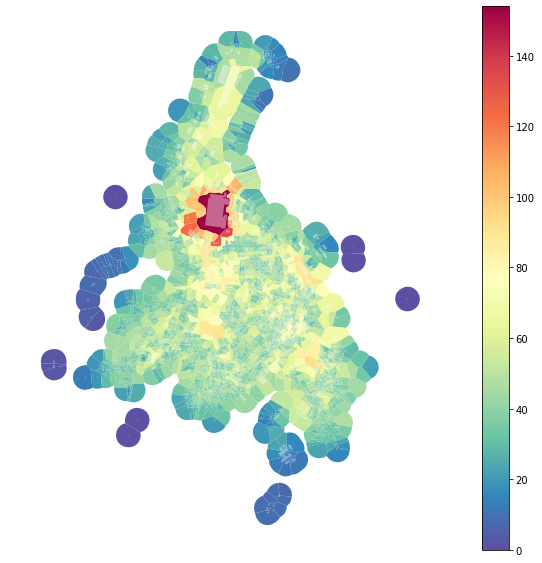

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighbours', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

## Distance

Often we want to define the neighbours based on metric distance. We will look at two options - distance band and k-nearest neighbour.

### Distance band

We can imagine distance band as a buffer of a set radius around each object, for example, 400 meters. For that, we can use `libpysal.weights.DistanceBand`:

In [6]:
import libpysal
dist400 = libpysal.weights.DistanceBand.from_dataframe(buildings, 400,
                                                       ids='uID')

/Users/martin/anaconda3/envs/mmp_guide/lib/python3.7/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 324.
  warnings.warn(message)


Because we have defined spatial weights using uID, we can use `dist400` generated on buildings and use it on tessellation:

In [7]:
tessellation['neighbours400'] = momepy.Neighbors(tessellation, dist400, 'uID').series

100%|██████████| 2503/2503 [00:00<00:00, 9676.63it/s] 


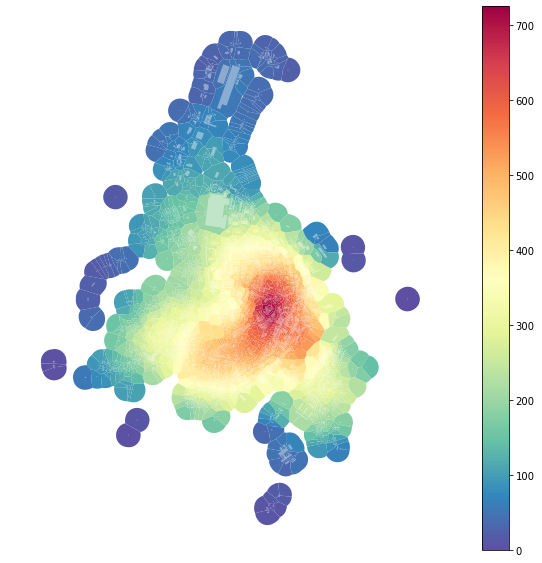

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighbours400', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### K nearest neighbor

If we want fixed number of neighbours, we can use `libpysal.weights.KNN`:

In [10]:
knn = libpysal.weights.KNN.from_dataframe(buildings, k=200, ids='uID')
tessellation['neighboursKNN'] = momepy.Neighbors(tessellation, knn,'uID').series

100%|██████████| 2503/2503 [00:00<00:00, 10445.49it/s]


**Note**: As all tessellation cells have the same number of neighbours (due to KNN), they all have the same colour.

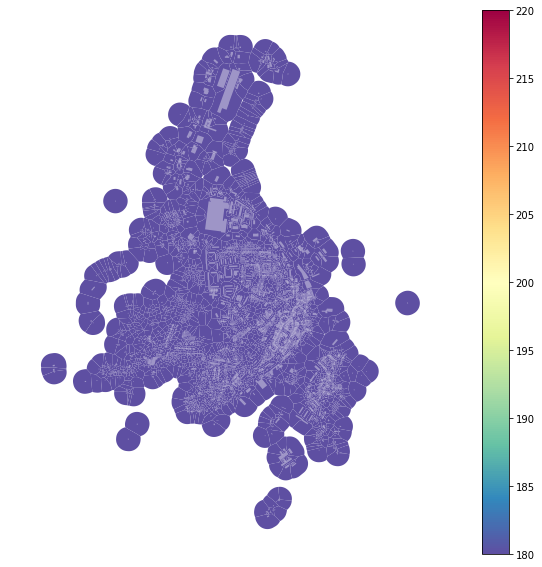

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighboursKNN', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

All of them can be used within morphometric analysis. Theoretical and practical differences are discussed in Fleischmann, Romice and Porta (2019).

For the other options on generating spatial weights see [lipysal API](https://pysal.org/libpysal/api.html).

#### References
- Fleischmann M, Romice O and Porta S (2019) Applicability of morphological tessellation and its topological derivatives in the quantitative analysis of urban form. XXVI International Seminar on Urban Form: Cities as Assemblages. In: Nicosia.